In [1]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import cv2
import string
import numpy as np
import tensorflow as tf
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Plot properties

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 15.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### ----------------------------------- Functions -----------------------------------

In [3]:
def bbox_threshold(left, top, width, height):
    valid_box = False
    # If the threshold box is less than 30
    if width * height < 15:
        valid_box = False
    elif left == 0 and top == 0 and\
         width == 0 and height == 0:
        valid_box = False
    else:
        valid_box = True

    return valid_box

In [4]:
def bb_intersection_over_union(boxA, boxB):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.

        p1 *-----
           |     |
           |_____* p2

    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

### ------------------ Captcha Localization and Detection -----------------------

In [5]:
from src.model_end2end import Model
from src.data_loader_end2end import dataLoader

#### Variables

In [37]:
# Change if needed
print_every      = 1000
batch_size       = 1
max_steps        = 6
lstm_hidden      = 128
pretrained_model = './model/lstm4/model-230'

### Load dataset

In [7]:
# Load train dataset
data = dataLoader(directory='./dataset', dataset_dir='test_cropped',\
            dataset_name='test.txt', max_steps=6, image_width=64,\
            image_height=64, grd_attn=False, mode='Test')

All data Loaded!


In [8]:
data.all_data[0]

[['1.png', 0, 0, 0, 1, 1],
 ['1.png', 5, 6, 7, 52, 50],
 ['1.png', 11, 62, 62, 1, 1],
 ['1.png', 11, 62, 62, 1, 1],
 ['1.png', 11, 62, 62, 1, 1],
 ['1.png', 11, 62, 62, 1, 1]]

In [9]:
n_iters = data.max_length # Test on all data
#n_iters = 400 # Test on small subset for debug purpose

In [10]:
print(n_iters)

13068


In [11]:
# Load Model
model = Model(dim_feature=[196, 128], dim_hidden=128, n_time_step=6,
              alpha_c=1.0, image_height=64, image_width=64, mode='test')
# Build model for inference
pred_bboxs_, pred_cptha_, alpha_list_ = model.build_test_model()

(?, 196, 128)
CNN build model sucess!


In [12]:
## Run FeedForward
# Collect predictions from runs for viz
vis_images  = []
attn_images = []
pred_cpthas = []
pred_bboxes = []
grnd_bboxes = []
grnd_labels = []
# Test Data Loader
test_gen = data.gen_data_batch(batch_size)
# Set GPU options
config = tf.GPUOptions(allow_growth=True)
# Session
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    # Load pre-trained
    if pretrained_model is not None:
        print("Start testing with pretrained Model..")
        saver.restore(sess, pretrained_model)
    else:
        print("Start testing with Model with random weights...")
    # Interations
    for i in range(n_iters):
        image_test_batch, viz_test_batch, grd_test_lables_batch, grd_test_bboxes_batch = next(test_gen)
        feed_dict = {model.images: image_test_batch,
                     model.is_train: False,
                     model.drop_prob: 1.0}
        prediction_bbox, prediction_cptha, prediction_alpha = sess.run([pred_bboxs_, pred_cptha_, alpha_list_], feed_dict)
        # Collect
        vis_images.append(viz_test_batch)
        pred_bboxes.append(prediction_bbox)
        pred_cpthas.append(prediction_cptha)
        attn_images.append(prediction_alpha)
        grnd_bboxes.append(grd_test_bboxes_batch)
        grnd_labels.append(grd_test_lables_batch)
        # Print every
        if i%print_every == 0:
            print('Inference Completion..{%d/%d}' % (i, n_iters))
    #-----------------------------------------------------
    print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
    print('Completed!')
# Close Session
sess.close()

Start testing with pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/lstm4/model-230
Inference Completion..{0/13068}
Inference Completion..{1000/13068}
Inference Completion..{2000/13068}
Inference Completion..{3000/13068}
Inference Completion..{4000/13068}
Inference Completion..{5000/13068}
Inference Completion..{6000/13068}
Inference Completion..{7000/13068}
Inference Completion..{8000/13068}
Inference Completion..{9000/13068}
Inference Completion..{10000/13068}
Inference Completion..{11000/13068}
Inference Completion..{12000/13068}
Inference Completion..{13000/13068}
Inference Completion..{13068/13068}
Completed!


In [15]:
print(len(vis_images))
print(len(attn_images))
print(len(pred_bboxes))
print(len(grnd_bboxes))
print(len(grnd_labels))
print(len(pred_cpthas))

13068
13068
13068
13068
13068
13068


In [33]:
grnd_bboxes[0][0]

array([[ 0.,  0.,  1.,  1.],
       [ 6.,  7., 52., 50.],
       [61., 61.,  1.,  1.],
       [61., 61.,  1.,  1.],
       [61., 61.,  1.,  1.],
       [61., 61.,  1.,  1.]])

### Compute sequence IOU score and prediction accuracy

In [49]:
count = 0.0
final_IOU_score   = 0.0
final_seq_acc_prd = 0.0
valid_seq_length  = []

In [50]:
for t in range(n_iters):
    sample_seq = 0
    sample_iou = 0.0
    sample_acc_prd = 0.0
    for T in range(max_steps):
        ## Ground
        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]
        
        ## Predicted
        sample_left  = int(pred_bboxes[t][T][0][0])
        sample_top   = int(pred_bboxes[t][T][0][1]) 
        sample_width = int(pred_bboxes[t][T][0][2])
        sample_heigt = int(pred_bboxes[t][T][0][3])
        
        vld_bbox_prd = bbox_threshold(left=sample_left, top=sample_top,\
                                width=sample_width, height=sample_heigt)

        vld_bbox_grd = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                width=sample_width_grd, height=sample_heigt_grd)
        
        if vld_bbox_grd:
            sample_seq += 1
            if vld_bbox_prd:
                # Predicted
                sample_right = sample_left + sample_width
                sample_down  = sample_top  + sample_heigt
                # Ground truth
                sample_right_grd = sample_left_grd + sample_width_grd
                sample_down_grd  = sample_top_grd  + sample_heigt_grd
                boxA = (sample_left, sample_top, sample_right, sample_down)
                boxB = (sample_left_grd, sample_top_grd, sample_right_grd, sample_down_grd)
                # Compute IOU
                sample_iou += bb_intersection_over_union(boxA, boxB)
                # Label
                sample_label = np.argmax(grnd_labels[t][0][T])
                # Predicted
                pred_score = np.argmax(pred_cpthas[t][T][0])
                # Predictions
                if int(pred_score) == int(sample_label):
                    sample_acc_prd += 1.0
    # Accumlate
    valid_seq_length.append(sample_seq)
    final_IOU_score += sample_iou/sample_seq
    final_seq_acc_prd += sample_acc_prd/sample_seq
    # Print Every
    if t%print_every == 0:
        print('Inference Completion..{%d/%d}' % (t, n_iters))
    count += 1.0
#-----------------------------------------------------
print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
print('Completed!')

Inference Completion..{0/13068}
Inference Completion..{1000/13068}
Inference Completion..{2000/13068}
Inference Completion..{3000/13068}
Inference Completion..{4000/13068}
Inference Completion..{5000/13068}
Inference Completion..{6000/13068}
Inference Completion..{7000/13068}
Inference Completion..{8000/13068}
Inference Completion..{9000/13068}
Inference Completion..{10000/13068}
Inference Completion..{11000/13068}
Inference Completion..{12000/13068}
Inference Completion..{13000/13068}
Inference Completion..{13068/13068}
Completed!


In [51]:
print('Predict Sequence IOU score = ', np.ceil((final_IOU_score/count)*100), '%')
print('Predict Sequence Classification Accuracy: ', np.ceil((final_seq_acc_prd/count)*100), '%')

Predict Sequence IOU score =  82.0 %
Predict Sequence Classification Accuracy:  93.0 %


### Visualization

In [43]:
shift_viz = 500

In [46]:
## Upscale attention mask
upscaled_attn_images = []
for k in range(0, n_iters, shift_viz):
    sample_attention_res_interm = []
    for K in range(1, 6, 1):
        sample_attn_reshaped = np.reshape(attn_images[k][K], (14, 14))
        sample_attention_res = skimage.transform.pyramid_expand(sample_attn_reshaped, upscale=4.55, sigma=1, multichannel=False)
        sample_attention_res_interm.append(sample_attention_res)
    
    upscaled_attn_images.append(sample_attention_res_interm)

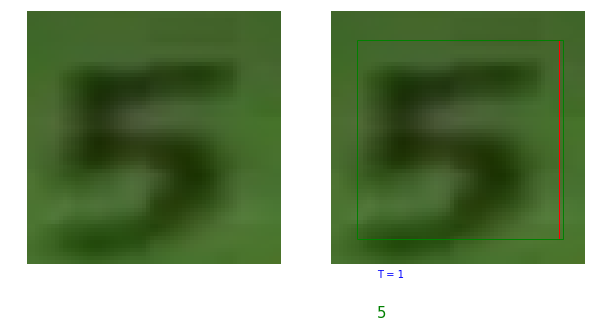

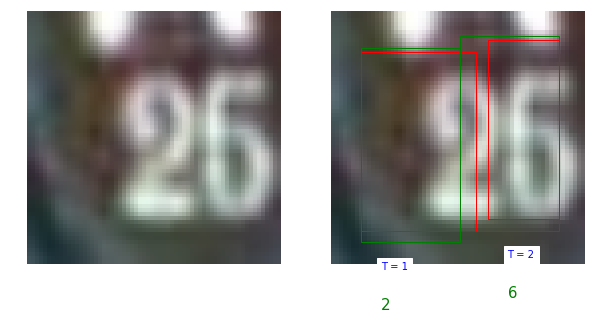

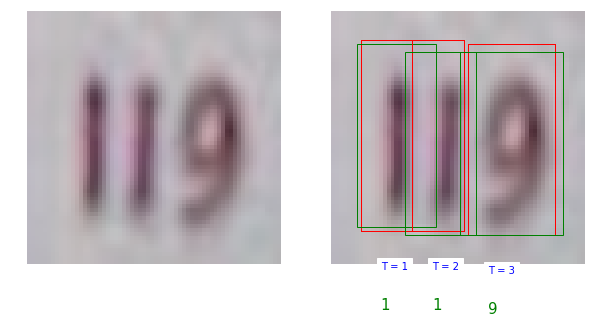

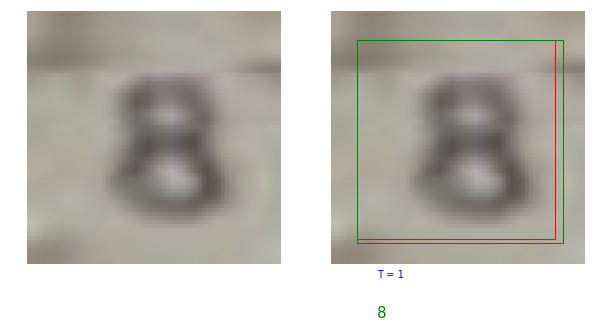

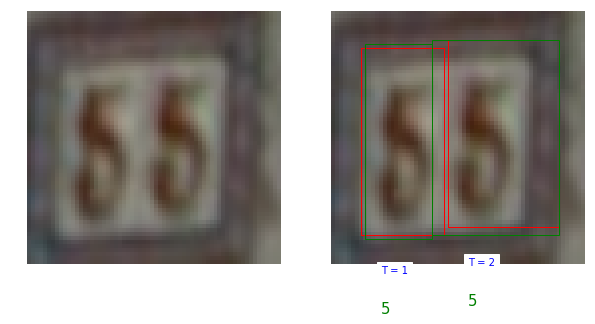

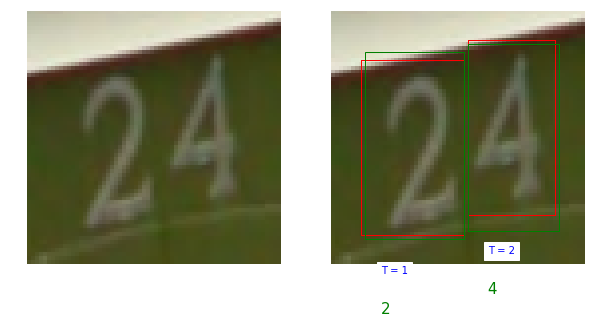

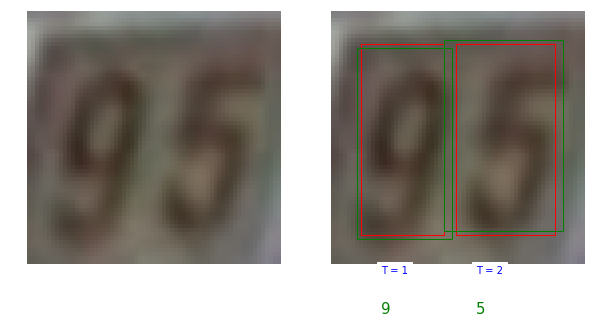

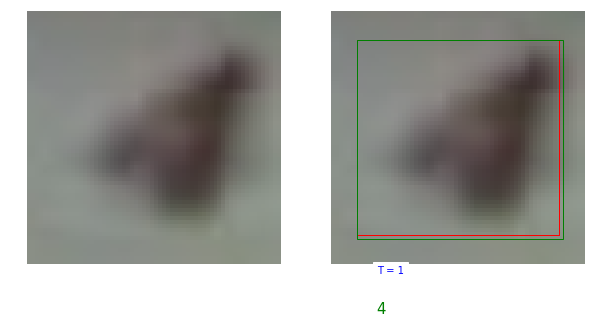

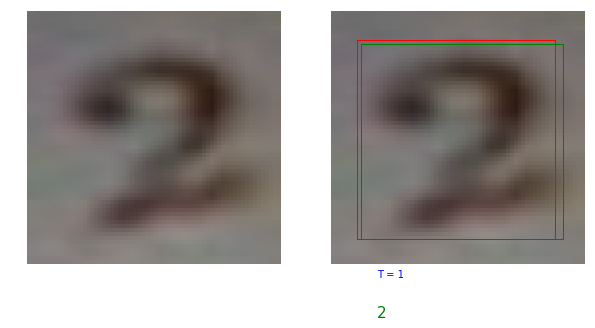

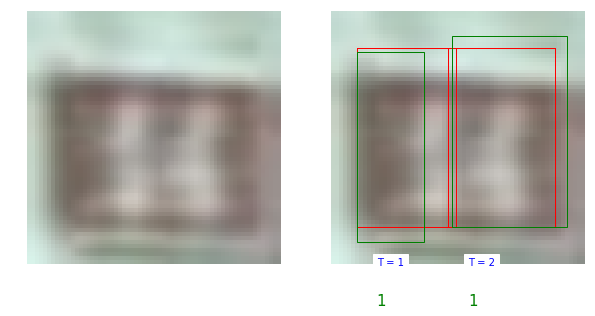

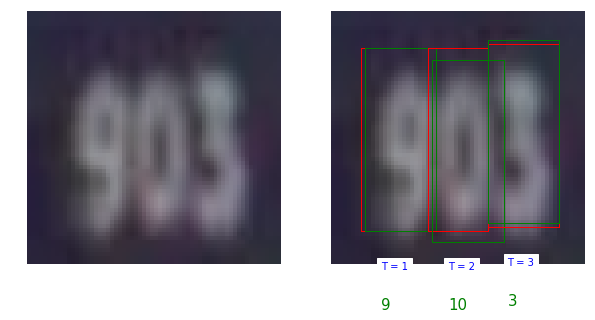

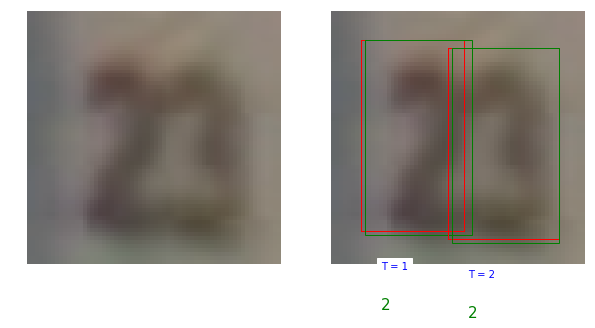

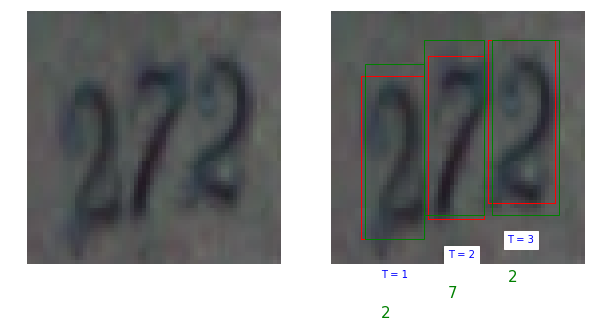

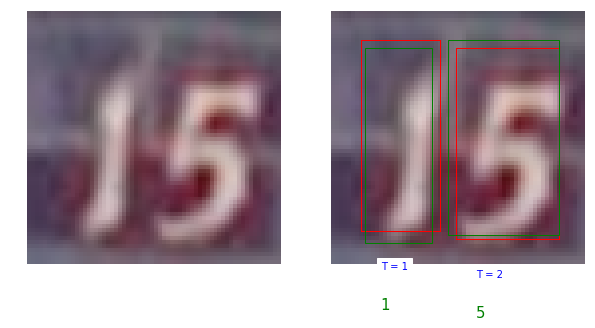

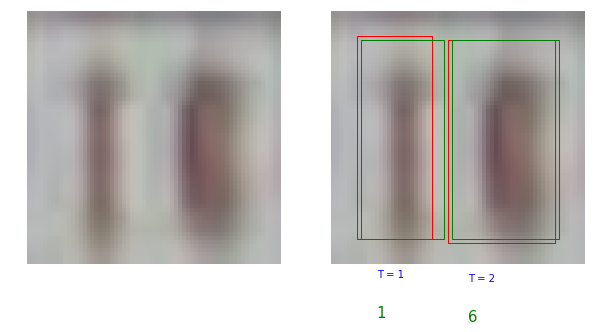

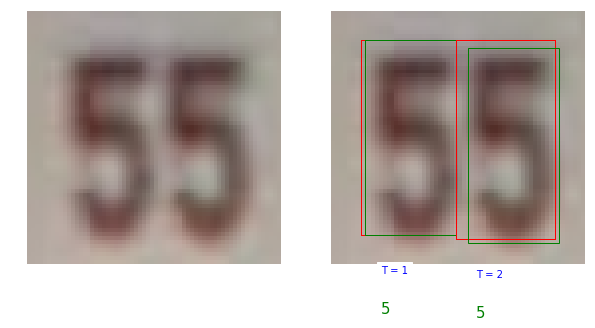

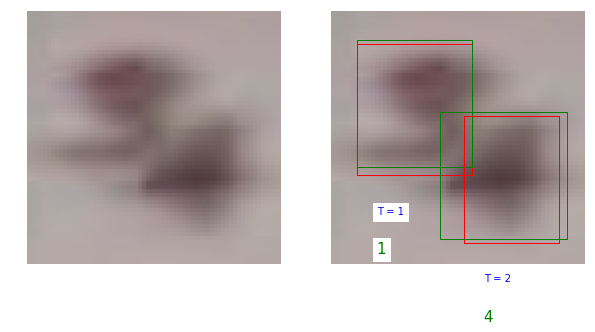

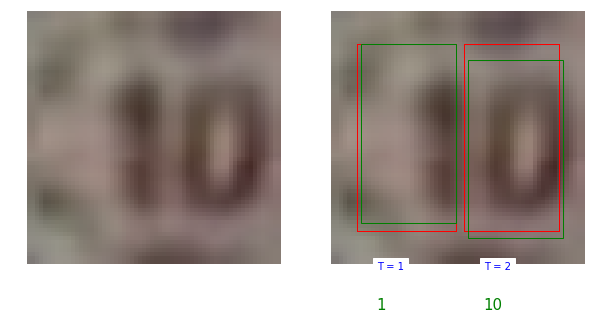

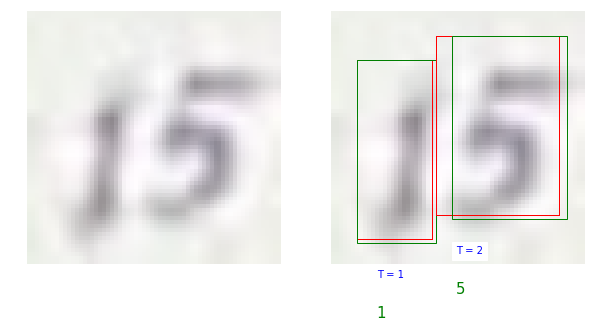

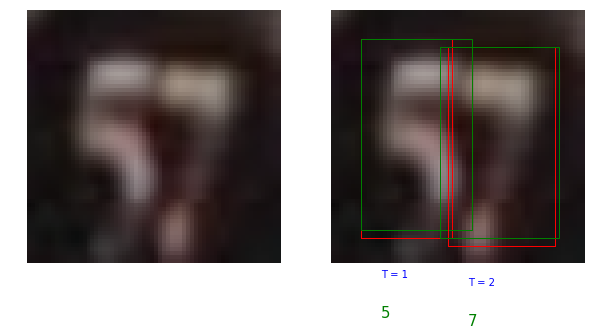

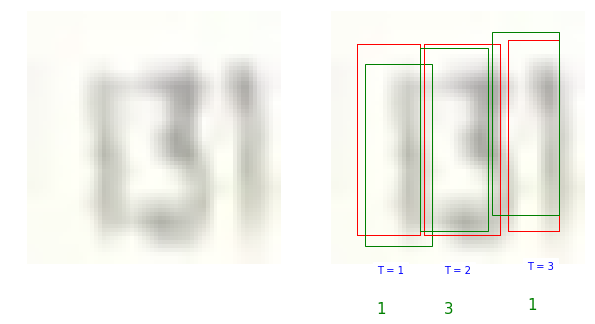

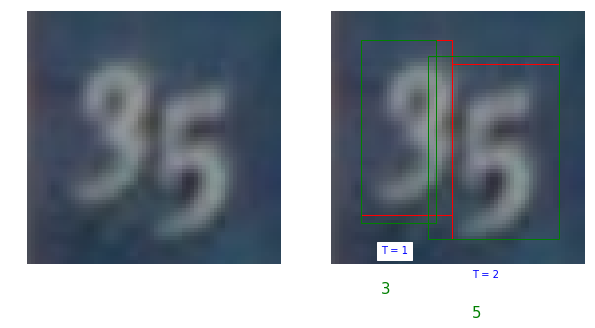

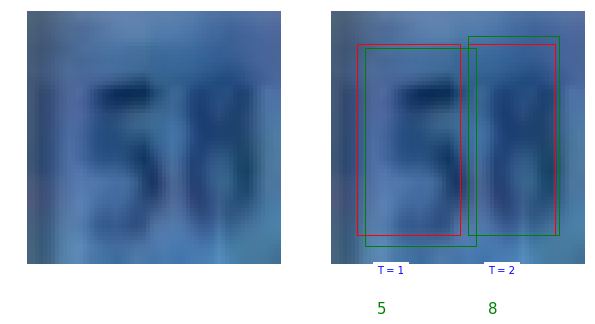

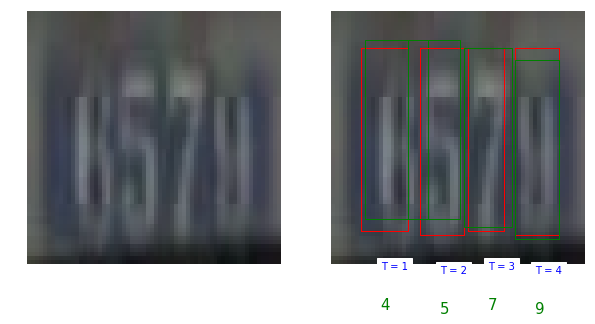

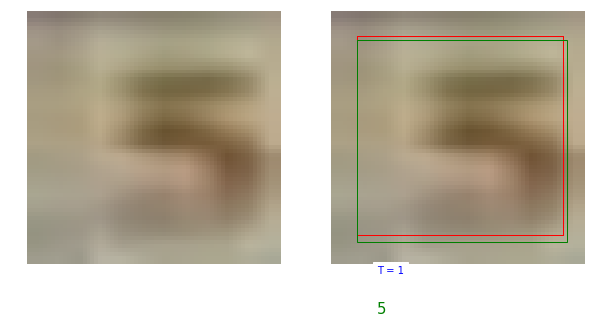

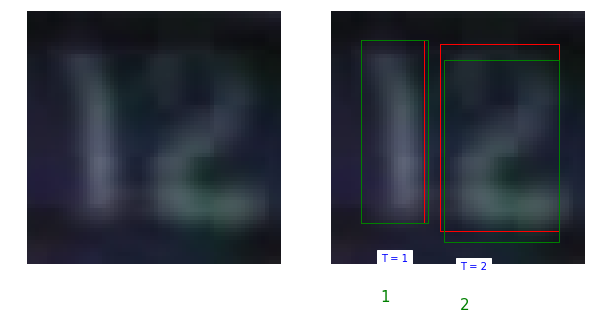

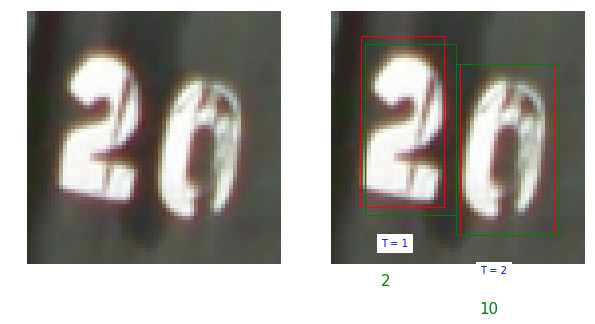

In [58]:
for t in range(0, n_iters, shift_viz):
    # Plot original image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(vis_images[t][0])
    ax[0].axis('off')
    ax[1].imshow(vis_images[t][0])
    val_seq = valid_seq_length[t]
    for T in range(1, val_seq+1):
        # ax[1].imshow(upscaled_attn_images[count][T], alpha=0.5)
        
        # Ground
        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]

        sample_left  = int(pred_bboxes[t][T][0][0])
        sample_top   = int(pred_bboxes[t][T][0][1])
        sample_width = int(pred_bboxes[t][T][0][2])
        sample_heigt = int(pred_bboxes[t][T][0][3])
                
        rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  
        rect2 = patches.Rectangle((sample_left_grd, sample_top_grd), sample_width_grd, sample_heigt_grd,linewidth=1,edgecolor='g',facecolor='none')  
        
        #ax[T+1].text(0, 1, (int(sample_left), int(sample_top), int(sample_width), int(sample_heigt)), color='black', backgroundcolor='white', fontsize=7)
        #ax[T+1].text(0, 56, 'iou: ' + str(np.round(iou_sample, decimals=3)), color='black', backgroundcolor='white', fontsize=7)
        text_x = int(sample_left + 5)
        text_y = int(sample_top + sample_heigt + 10)
        ax[1].text(text_x, text_y, 'T = ' + str(T), color='blue', backgroundcolor='white', fontsize=10)
        ax[1].text(text_x, text_y+10, str(np.argmax(grnd_labels[t][0][T])), color='red', backgroundcolor='white', fontsize=15)
        ax[1].text(text_x, text_y+10, str(np.argmax(pred_cpthas[t][T][0])), color='green', backgroundcolor='white', fontsize=15)
        ax[1].add_patch(rect1)
        ax[1].axis('off')
        ax[1].add_patch(rect1)
        ax[1].add_patch(rect2)
        ax[1].axis('off')
        
    plt.show()